# Multiplicative production function

Most SFA studies use Cobb-Douglas or translog functional forms where inefficiency and noise affect production in a multiplicative fashion. Note that the assumption of constant returns to scale (CRS) would also require multiplicative error structure. 

In the context of VRS, the log-transformed `CNLS` formulation:

\begin{align*}
& \underset{\alpha, \beta, \varepsilon} {min} \sum_{i=1}^n\varepsilon_i^2 \\
& \text{s.t.} \\
&  \text{ln}y_i = \text{ln}(\phi_i+1) + \varepsilon_i  \quad \forall i\\
& \phi_i  = \alpha_i+\beta_i^{'}X_i -1 \quad \forall i \\
&  \alpha_i + \beta_i^{'}X_i \le \alpha_j + \beta_j^{'}X_i  \quad  \forall i, j\\
&  \beta_i \ge 0 \quad  \forall i \\
\end{align*}

The CRS log-transformed `CNLS` formulation:

\begin{align*}
& \underset{\alpha, \beta, \varepsilon} {min} \sum_{i=1}^n\varepsilon_i^2 \\
& \text{s.t.} \\
&  \text{ln}y_i = \text{ln}(\phi_i+1) + \varepsilon_i  \quad \forall i\\
& \phi_i  = \beta_i^{'}X_i -1 \quad \forall i \\
&  \beta_i^{'}X_i \le \beta_j^{'}X_i  \quad  \forall i, j\\
&  \beta_i \ge 0 \quad  \forall i \\
\end{align*}

where $\phi_i+1$ is the CNLS estimator of $E(y_i|x_i)$. The value of one is added here to make sure that the computational algorithms do not try to take logarithm of zero. The first equality can be interpreted as the log transformed regression equation (using the natural logarithm function $ln(.)$). The rest of constraints 
are similar to additive production function model. The use of $\phi_i$ allows the estimation of a multiplicative relationship between output and input while assuring convexity of the production possibility set in original input-output space.

# CNLS - Multiplicativo com função de produção (Resultados iguais aos do método StoNED)

## Modelo VRS sem variáveis contextuais

In [1]:
#! pip install pymo
#
#! pip install pystone
# fix jedi
#%config Completer.use_jedi = False
#%load_ext lab_black

In [8]:
# import packages
from pystoned import CNLS
from pystoned import StoNED
import pandas as pd
import numpy as np

In [9]:
# Necessário para utilizar os solvers do servidor NEOS
from pyomo import environ as pym
import os

# provide an email address
os.environ["NEOS_EMAIL"] = "carlos.vneves@gmail.com"
solver_manager = pym.SolverManagerFactory("neos")

In [12]:
# import highway brazilian federal concessions data - mean filtered data
url = 'https://raw.githubusercontent.com/carlosvneves/__TESE_code-data/main/data/data_eff.csv?token=AC5PIDMZEZ6XIGTID66JFV3AGUQGE'
df = pd.read_csv(url, error_bad_lines=False)
#df = pd.read_csv("data_sfa.csv", error_bad_lines=False)



In [14]:
df["dmu"] = df["Unnamed: 0"]
df = df.drop("Unnamed: 0", axis=1)
df = df.set_index("dmu")
df.head(10)


,conc,avg,rec,cust,tar,ext,npp,etp,dEtp2,dEtp3
dmu,,,,,,,,,,
1,AUTOFERNAODIAS,3.374,502.796335,858.192097,1.946011,562.099976,8,2,1,0
2,AUTOFLUMINENSE,3.800,606.137121,1354.908762,4.198651,320.100006,5,2,1,0
3,AUTOLITORALSUL,3.756,652.230614,1385.064295,2.132276,382.299988,5,2,1,0
4,AUTOPLANALTOSUL,3.562,306.581657,690.202454,5.064284,412.700012,5,2,1,0
5,AUTOREGIS,4.224,806.160540,1473.365598,2.557376,401.600006,6,2,1,0
6,CCRPONTE,4.000,14207.258021,6771.043772,6.264905,13.200000,1,1,0,0
7,CONCEBRA,3.575,236.074096,504.654252,3.537352,1176.500000,11,3,0,1
8,CONCEPA,3.086,2503.079080,2370.388300,12.589375,121.000000,3,1,0,0
9,CONCER,3.800,1640.679387,2111.345648,11.225488,179.899994,3,1,0,0


In [14]:
# output
y = np.log(df['avg'])

# inputs
x1 = df['rec']
x1 = np.log(np.asmatrix(x1).T)
x2 = df['cust']
x2 = np.log(np.asmatrix(x2).T)
x = np.concatenate((x1, x2), axis=1)

In [18]:
# define and solve the CNLS model
model = CNLS.CNLS(y, x, z=None, cet = "mult", fun = "prod", rts = "vrs")
model.optimize(remote=True)

Estimating the multiplicative model remotely with knitro solver


In [20]:
# store the beta 
beta = model.get_beta()
# production df
prod_df = pd.DataFrame(data=[np.exp(beta[:,0]),np.exp(beta[:,1])])
prod_df = prod_df.transpose()
prod_df.columns = ["Custos","Receitas"]
elasticity = prod_df["Custos"]/prod_df["Receitas"]
prod_df.insert(2,"Elasticidade",elasticity)

In [21]:
prod_df.describe()


,Custos,Receitas,Elasticidade
count,21.000000,21.000000,21.000000
mean,5.375065,1.133096,4.665011
std,15.257646,0.394555,14.690508
min,1.003189,1.000000,0.527994
25%,1.009558,1.000000,1.009558
50%,1.009558,1.000000,1.009558
75%,1.009558,1.000000,1.009558
max,68.749607,2.458176,68.291854


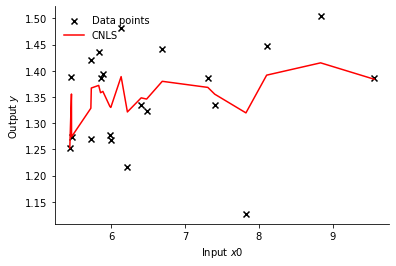

In [22]:
model.plot2d(0)

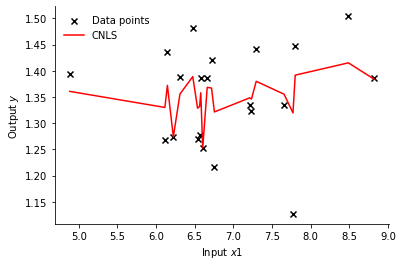

In [23]:
model.plot2d(1)

In [24]:
# store the residual
eps = model.get_residual()
eps

array([-1.05352775e-01, -1.33839001e-02, -2.26613021e-02, -5.82416718e-02,
        6.08674375e-02,  2.38318436e-03, -3.98698461e-10, -1.92788276e-01,
       -2.03603379e-02,  5.35908077e-02,  1.79958759e-02, -6.16983916e-02,
        8.89269234e-02,  3.40613541e-02,  2.81952524e-02, -7.65581746e-10,
        5.52484349e-02,  9.27223468e-02,  6.29644493e-02,  3.18809970e-02,
       -5.43504075e-02])

## Compute Efficiency

In [25]:
ubenchmark = max(eps)
yhat = model.get_frontier()
# The purpose of this line is to impose monotonicity
uCNLS = ubenchmark - eps
# The purpose of this line is to impose monotonicity by
phiC2NLS = yhat + ubenchmark
# Farrel efficiency scores
thetaC2NLS = yhat / phiC2NLS
thetaC2NLS

array([0.93578487, 0.93586385, 0.93589476, 0.93557491, 0.93598396,
       0.93716793, 0.93215542, 0.93645678, 0.93628132, 0.93557754,
       0.93624229, 0.93568975, 0.93687296, 0.93564405, 0.93563074,
       0.93108632, 0.93657276, 0.93574894, 0.93561992, 0.93546281,
       0.93568437])

In [26]:
# Calcula eficiência técnica na forma do SFA
ustar = -(eps - ubenchmark)
theta = np.exp(-ustar)
theta

array([0.82030823, 0.89932909, 0.89102424, 0.85987864, 0.96864711,
       0.91362127, 0.91144653, 0.75163036, 0.89307681, 0.96162421,
       0.92799729, 0.85691141, 0.99621177, 0.94302641, 0.93751071,
       0.91144653, 0.96321955, 1.        , 0.97068051, 0.94097251,
       0.86323117])

In [53]:
eff_cnls = np.asmatrix(theta

# StoNED (VRS) - Multiplicativo sem variáveis contextuais

In [27]:
# StoNED model
# define and solve the CNLS model
model_st = StoNED.StoNED(y, x, z=None, cet = "mult", fun = "prod", rts = "vrs")
model_st.optimize(remote=True)

Estimating the multiplicative model remotely with knitro solver


In [28]:
# store the beta 
beta_st = model_st.get_beta()
# production df
prod_df_st = pd.DataFrame(data=[beta_st[:,0],beta_st[:,1]])
prod_df_st = prod_df_st.transpose()
prod_df_st.columns = ["Custos","Receitas"]
elasticity_st = prod_df_st["Custos"]/prod_df_st["Receitas"]
prod_df_st.insert(2,"Elasticidade",elasticity_st)

In [74]:
prod_df_st.describe()


,Custos,Receitas,Elasticidade
count,2.100000e+01,2.100000e+01,2.100000e+01
mean,6.976813e-02,1.584762e-01,2.495486e+07
std,2.808490e-01,4.277607e-01,1.143568e+08
min,2.607699e-12,1.229243e-14,4.989270e-08
25%,9.490666e-12,5.226609e-05,2.443923e-07
50%,8.101703e-11,5.226621e-05,2.492243e-06
75%,6.494104e-05,5.226809e-05,2.776593e-01
max,1.284558e+00,1.544998e+00,5.240487e+08


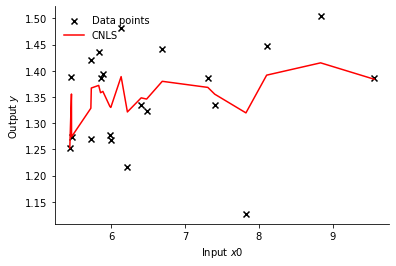

In [29]:
model_st.plot2d(0)

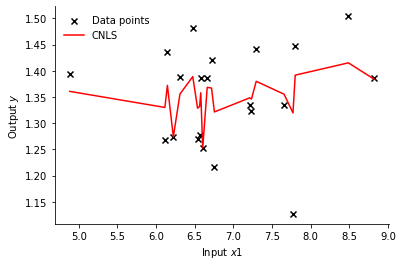

In [30]:
model.plot2d(1)

In [62]:
# store the residual
eps_st = model_st.get_residual()
eps_st

array([-1.05352775e-01, -1.33839001e-02, -2.26613021e-02, -5.82416718e-02,
        6.08674375e-02,  2.38318436e-03, -3.98698461e-10, -1.92788276e-01,
       -2.03603379e-02,  5.35908077e-02,  1.79958759e-02, -6.16983916e-02,
        8.89269234e-02,  3.40613541e-02,  2.81952524e-02, -7.65581746e-10,
        5.52484349e-02,  9.27223468e-02,  6.29644493e-02,  3.18809970e-02,
       -5.43504075e-02])

In [61]:
# Calcula eficiência técnica na forma do SFA
ubenchmark = max(eps_st)
ustar_st = -(eps_st - ubenchmark)
theta_st = np.exp(-ustar_st)
theta_st

array([0.82030823, 0.89932909, 0.89102424, 0.85987864, 0.96864711,
       0.91362127, 0.91144653, 0.75163036, 0.89307681, 0.96162421,
       0.92799729, 0.85691141, 0.99621177, 0.94302641, 0.93751071,
       0.91144653, 0.96321955, 1.        , 0.97068051, 0.94097251,
       0.86323117])

In [64]:
# Quassi-likelihood estimation for technical inneficiency (works with vrs)
eff_st = np.asmatrix(model_st.get_technical_inefficiency(method='QLE')).T

# StoNEZD (VRS) - Multiplicativo com variáveis contextuais (Z-variables)

A firm’s ability to operate efficiently often depends on operational conditions 
and practices, such as the production environment and the firm specific 
characteristics for  example  technology  selection  or  managerial  
practices.  Banker  and  Natarajan (2008) refer to both variables that 
characterize operational conditions and practices as `contextual variables`.

* Contextual variables are often (but not always) **external factors** that are beyond the control of firms

    - Examples: competition, regulation, weather, location

    - Need to adjust efficiency estimates for operating environment

    - Policy makers may influence the operating environment

* Contextual variables can also be **internal factors**

    - Examples: management practices, ownership
    
    - Better understanding of the impacts of internal factors can help the firm to improve performance


Taking the multiplicative model as our starting point, 
we introduce the contextual variables, represented by `r`-dimensional vectorszi that 
represent the measured values of operational conditions and practices, to obtain 
the following semi-nonparametric, partial log-linear equation


   \begin{align*}
        \text{ln} y_i = \text{ln} f(\bf x_i) + \delta^{'}Z_i + v_i - u_i.
   \end{align*}

In this equation, parameter vector $\delta=(\delta_1...\delta_r)$ represents the 
marginal effects ofcontextual variables on output. All other variables maintain their 
previous definitions.

Following Johnson and Kuosmanen (2011), we incorporate the contextual variables in step 1 of 
the StoNED estimation routine and refine the multiplicative CNLS problem as follows:

   \begin{align*}
        & \underset{\alpha, \beta, \varepsilon} {min} \sum_{i=1}^n\varepsilon_i^2 \\
        & \text{s.t.} \\
        &  \text{ln} y_i = \text{ln}(\phi_i+1) + \delta^{'}z_i + \varepsilon_i  \quad \forall i\\
        &   \phi_i  = \alpha_i + \beta_i^{'}X_i -1 \quad \forall i \\
        &  \alpha_i + \beta_i^{'}X_i \le \alpha_j + \beta_j^{'}X_i  \quad  \forall i, j\\
        &  \beta_i \ge 0 \quad  \forall i \\
   \end{align*}

Denote by $\delta^{StoNEZD}$ the coefficients  of  the contextual variables 
obtained as theoptimal solution to above nonlinear problem. Johnson and Kuosmanen (2011) examine the statisticalproperties of this estimator in 
detail, showing its unbiasedness, consistency, and asymptotic efficiency.

In [34]:
# output
y = np.log(df["avg"])

# inputs
x1 = df["cust"]
x1 = np.log(np.asmatrix(x1).T)
x2 = df["rec"]
x2 = np.log(np.asmatrix(x2).T)
x = np.concatenate((x1, x2), axis=1)

# Z variables
# z = df['npp', 'ext', 'tar', 'dEtapa2', 'dEtapa3']
z1 = df["npp"]
z1 = np.asmatrix(z1).T

z2 = df["ext"]
z2 = np.asmatrix(z2).T

z3 = df["tar"]
z3 = np.asmatrix(z3).T

z4 = df["dEtp2"]
z4 = np.asmatrix(z4).T

z5 = df["dEtp3"]
z5 = np.asmatrix(z5).T

# z = np.concatenate((z1, z2, z3, z4, z5), axis=1)
z = np.concatenate((z1, z3, z4, z5), axis=1)

In [35]:
# define and solve the StoNED model using KDE approach
model_stz = StoNED.StoNED(y, x, z, cet="mult", fun="prod", rts="vrs")
model_stz.optimize(remote=True)

Estimating the multiplicative model remotely with knitro solver


In [51]:
# retrive the technical inefficiency
eff_stz = np.asmatrix(model_stz.get_technical_inefficiency(method="MOM") ).T


In [38]:
def SqB1Test(eps, n):
    """docstring"""
    Flag = 0
    # Calculate the first and second moments for each observation
    M2 = np.power(eps, 2)
    M3 = np.power(eps, 3)
    # calculate the average moment
    mM2 = np.mean(M2)
    mM3 = np.mean(M3)

    if 0 < mM3:
        mM3 = -0.0001
        Flag = 1

    teststat = mM3 / (mM2 ** (3 / 2))

    m = 1000

    S = np.zeros(n)
    teststatt = np.zeros(m)
    # Calculates the number of time a test statistic calculate from random
    # draws from a normal distribution is more negative the the one
    # calculated from the data set
    Flag1 = 0
    for j in range(m):
        for i in range(n):
            S[i] = np.random.normal(0, np.sqrt(mM2))

        M2t = np.power(S, 2)
        M3t = np.power(S, 3)
        mM2t = np.sum(M2t / (n - 1))
        mM3t = np.sum(M3t / (n - 1))
        teststatt[j] = mM3t / (mM2t) ** (3 / 2)
        if teststatt[j] < teststat:
            Flag1 = Flag1 + 1

    Pvalue = Flag1 / m

    return [teststat, teststatt, Pvalue, Flag]

In [39]:
eps = model_stz.get_residual()
n = df.shape[0]

teststat, teststatt, Pvalue, Flag = SqB1Test(eps, n)

In [40]:
Pvalue

0.115

## DEA VRS: Radial Model - Output Orientation

A set of $j= 1,2,\cdots,n$ observed `DMUs` transform a vector of $i = 1, 2,\cdots,m$ inputs $x \in R^m_{++}$ into a vector of $i = 1, 2, \cdots, s$ outputs $y \in R^s_{++}$ using the technology represented by the following CRS production possibility set: $P_{crs} = \{(x, y) |x \ge X\lambda, y \le Y\lambda, \lambda \ge 0\}$, where $X = (x)_j \in R^{s \times n}$, $Y =(y)_j \in R^{m \times n}$ and $\lambda = (\lambda_1, . . . , \lambda_n)^T$ is a intensity vector.

Based on the data matrix `(X, Y)`, we measure the input oriented efficiency of `each observation o` by solving `n` times the following linear programming problems: 

### Constant returns to scale: CRS

\begin{align*}
        \underset{\mathbf{\theta},\mathbf{\lambda }}max \quad \theta \\ 
        \mbox{s.t.} \quad 
        X\lambda  \le x_o \\
        \theta y_o  \le Y\lambda\\
        \lambda \ge 0
   \end{align*}

### Variables returns to scale: VRS

The measurement of technical efficiency assuming VRS considers the following production possibility set $P_{vrs} = \{ (x, y) |x \ge X\lambda, y \le Y\lambda, e\lambda = 1, \lambda \ge 0. \}$

Thus, the only difference with the CRS model is the adjunction of the condition $\sum_{j=1}^{n}\lambda_j = 1$. 

   \begin{align*}
        \underset{\mathbf{\theta},\mathbf{\lambda }}max \quad \theta \\ 
        \mbox{s.t.} \quad 
        X\lambda  \le x_o \\
        \theta y_o  \le Y\lambda\\
        \sum_{j=1}^{n}\lambda_j = 1 \\
        \lambda \ge 0
   \end{align*}





In [79]:
from pystoned import DEA


In [84]:
# define and solve the DEA radial model
model_dea = DEA.DEA(y,x,rts ="vrs", orient="oo", yref=None, xref=None)
model_dea.optimize(remote=True)

Estimating the model remotely with mosek solver


In [85]:
# display the technical efficiency
model_dea.display_theta()

theta : efficiency
    Size=21, Index=I
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :  None : 1.2189062056865436 :  None : False : False :  Reals
      1 :  None : 1.1115089531885234 :  None : False : False :  Reals
      2 :  None : 1.1217518112347686 :  None : False : False :  Reals
      3 :  None : 1.1212060814045817 :  None : False : False :  Reals
      4 :  None : 1.0315492169396066 :  None : False : False :  Reals
      5 :  None : 1.0849625007211563 :  None : False : False :  Reals
      6 :  None :                1.0 :  None : False : False :  Reals
      7 :  None : 1.3272659224980359 :  None : False : False :  Reals
      8 :  None : 1.1177141908561827 :  None : False : False :  Reals
      9 :  None : 1.0031409609430877 :  None : False : False :  Reals
     10 :  None : 1.0702572094927394 :  None : False : False :  Reals
     11 :  None :  1.145168083787293 :  None : False : False :  Reals
     12 :  None :                1.0 :  None : Fal

In [89]:
eff_dea = model_dea.get_theta()
eff_dea = np.asmatrix(1./eff_dea).T


In [91]:
df_eff = np.concatenate((eff_dea,eff_cnls,eff_st,eff_stz), axis=1)
df_eff = pd.DataFrame(df_eff, columns=["eff_dea","eff_cnls","eff_st","eff_stz"])
df_eff["dmu"] = df.index
df_eff = df_eff.set_index("dmu")
df_eff = pd.concat([df,df_eff], axis=1)
df_eff

,conc,avg,rec,cust,tar,ext,npp,etp,dEtp2,dEtp3,eff_dea,eff_cnls,eff_st,eff_stz
dmu,,,,,,,,,,,,,,
1,AUTOFERNAODIAS,3.374,502.796335,858.192097,1.946011,562.099976,8,2,1,0,0.820408,0.820308,0.829694,0.867607
2,AUTOFLUMINENSE,3.800,606.137121,1354.908762,4.198651,320.100006,5,2,1,0,0.899678,0.899329,0.907808,0.918683
3,AUTOLITORALSUL,3.756,652.230614,1385.064295,2.132276,382.299988,5,2,1,0,0.891463,0.891024,0.899606,0.907751
4,AUTOPLANALTOSUL,3.562,306.581657,690.202454,5.064284,412.700012,5,2,1,0,0.891897,0.859879,0.868830,0.876706
5,AUTOREGIS,4.224,806.160540,1473.365598,2.557376,401.600006,6,2,1,0,0.969416,0.968647,0.974165,0.986645
6,CCRPONTE,4.000,14207.258021,6771.043772,6.264905,13.200000,1,1,0,0,0.921691,0.913621,0.921920,0.930712
7,CONCEBRA,3.575,236.074096,504.654252,3.537352,1176.500000,11,3,0,1,1.000000,0.911447,0.919773,0.928456
8,CONCEPA,3.086,2503.079080,2370.388300,12.589375,121.000000,3,1,0,0,0.753429,0.751630,0.761673,0.788509
9,CONCER,3.800,1640.679387,2111.345648,11.225488,179.899994,3,1,0,0,0.894683,0.893077,0.901633,0.927436


## Análise SFA (pacote frontier do R)

In [1]:
%load_ext rpy2.ipython

In [5]:
%%R
library(frontier)
data( front41Data )


R[write to console]: Carregando pacotes exigidos: micEcon

R[write to console]: 
If you have questions, suggestions, or comments regarding one of the 'micEcon' packages, please use a forum or 'tracker' at micEcon's R-Forge site:
https://r-forge.r-project.org/projects/micecon/

R[write to console]: Carregando pacotes exigidos: lmtest

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: 'zoo'


R[write to console]: The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


R[write to console]: 
Please cite the 'frontier' package as:
Tim Coelli and Arne Henningsen (2013). frontier: Stochastic Frontier Analysis. R package version 1.1. http://CRAN.R-Project.org/package=frontier.

If you have questions, suggestions, or comments regarding the 'frontier' package, please use a forum or 'tracker' at frontier's R-Forge site:
https://r-forge.r-project.org/projects/frontier/



In [15]:
%%R -i df

summary(df)

     conc                avg             rec               cust       
 Length:21          Min.   :3.086   Min.   :  230.5   Min.   : 132.3  
 Class :character   1st Qu.:3.575   1st Qu.:  340.8   1st Qu.: 648.6  
 Mode  :character   Median :4.000   Median :  461.9   Median : 781.9  
                    Mean   :3.874   Mean   : 1725.5   Mean   :1468.4  
                    3rd Qu.:4.140   3rd Qu.: 1494.0   3rd Qu.:1473.4  
                    Max.   :4.500   Max.   :14207.3   Max.   :6771.0  
      tar              ext              npp              etp       
 Min.   : 1.946   Min.   :  13.2   Min.   : 1.000   Min.   :1.000  
 1st Qu.: 3.907   1st Qu.: 200.4   1st Qu.: 3.000   1st Qu.:1.000  
 Median : 4.586   Median : 402.0   Median : 5.000   Median :2.000  
 Mean   : 6.194   Mean   : 452.4   Mean   : 5.381   Mean   :2.048  
 3rd Qu.: 6.477   3rd Qu.: 623.8   3rd Qu.: 7.000   3rd Qu.:3.000  
 Max.   :15.336   Max.   :1176.5   Max.   :11.000   Max.   :3.000  
     dEtp2           dEtp3 

In [34]:
%%R -i df 
#sfa_hn <- sfa( log( avg ) ~ log( rec ) + log( cust ) - 1| npp + ext + tar + dEtp2 + dEtp3 -1,data = df,ineffDecrease = TRUE, truncNorm = TRUE)
sfa_hn <- sfa( log( avg ) ~ log( rec ) + log( cust ), data = df,ineffDecrease = TRUE, truncNorm = FALSE)

summary(sfa_hn)

Error Components Frontier (see Battese & Coelli 1992)
Inefficiency decreases the endogenous variable (as in a production function)
The dependent variable is logged
Iterative ML estimation terminated after 4 iterations:
cannot find a parameter vector that results in a log-likelihood value
larger than the log-likelihood value obtained in the previous step

final maximum likelihood estimates
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  1.424062   0.669559  2.1269  0.03343 *
log(rec)     0.044454   0.493923  0.0900  0.92829  
log(cust)   -0.034950   0.569610 -0.0614  0.95107  
sigmaSq      0.022859   0.061764  0.3701  0.71131  
gamma        0.984317   0.996255  0.9880  0.32314  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
log likelihood value: 22.23339 

cross-sectional data
total number of observations = 21 

mean efficiency: 0.8851554 


In [28]:
%%R
efficiencies(cobbDouglas)

   efficiency
1   0.9890761
2   0.9839890
3   0.9812597
4   0.9861161
5   0.9863698
6   0.4338834
7   0.9902225
8   0.6190466
9   0.6855879
10  0.9878916
11  0.6437160
12  0.9768559
13  0.5942016
14  0.8981859
15  0.9715629
16  0.9879965
17  0.6964857
18  0.9812938
19  0.9845994
20  0.9912856
21  0.9886697


In [1]:
import ipystata
#from ipystata.config import config_syntax_higlight    
#config_syntax_higlight(False)

Terminated 1 unattached Stata session(s).


In [2]:
%%stata  
display "Hello, I am printed in Stata." 

In [3]:
%%stata
       sessions

In [48]:
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize


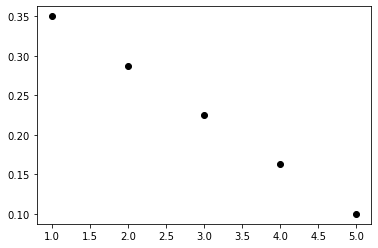

In [169]:
x = np.linspace(1.,5.,5) 
y = np.linspace(.35,.10,5)
plt.plot(x,y,'o',color='black')


In [155]:
# Function to calculate the exponential with constants a and b
def objective(x, a, b):
    y = a*np.exp(b*x)

    return y

    


In [156]:
popt, _  = optimize.curve_fit(f=objective, xdata=x, ydata=y)
popt

array([ 0.47420884, -0.27148318])

In [157]:
y_adj = popt[0] * np.exp(popt[1] * np.linspace(1,5,5)) 
y_adj


array([0.36146479, 0.27552585, 0.21001905, 0.16008663, 0.12202573])

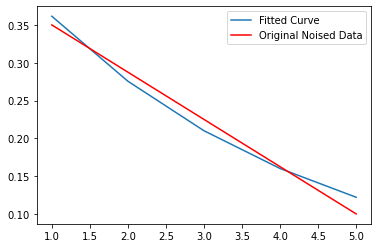

In [158]:
plt.plot(x,y_adj,'-',label="Fitted Curve")
plt.plot(x, y, 'r-',label="Original Noised Data")
plt.legend()
plt.show()


In [188]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian


def residual(pars, x, data):
    model = (pars['a']*np.exp(pars['b']*x))
    return model - data

In [189]:
data = y

In [190]:
pfit = Parameters()
pfit.add(name='a', value=0.4, min=0.0, max=0.5, vary=True)
pfit.add(name='b', value=-0.5, min=-1., max=0, vary=True)
pfit.add(name='y', value=0.25, min=.1, max=.35, vary=True)

mini = Minimizer(residual, pfit, fcn_args=(x, data))
out = mini.leastsq()
best_fit = data + out.residual

In [191]:
report_fit(out.params)

[[Variables]]
    a:  0.50000000 +/- 0.62463257 (124.93%) (init = 0.4)
    b: -0.15668431 +/- 0.34433479 (219.76%) (init = -0.5)
    y:  0.10000000 +/- 0.69476362 (694.76%) (init = 0.25)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, y) =  0.998
    C(b, y) =  0.996
    C(a, b) =  0.987


In [194]:
delta_i = 1-.8
p_t = [.34,.25,.18,.13,.10]


In [195]:
np.sum(p_t)

1.0

In [198]:
X_t = np.multiply(p_t,delta_i) 
X_t

array([0.068, 0.05 , 0.036, 0.026, 0.02 ])

In [199]:
sum(X_t)

0.19999999999999996